## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader, random_split

cudnn.benchmark = True
plt.ion()

Load data and create Dataloaders

In [2]:
from utils import SymbolDataset, encode_labels

data_dir = 'symbols_2000_1.npz'
data = np.load(data_dir)
images = data['images']
labels = data['labels']

class_names, labels_nums = encode_labels(labels)

images_tensor = torch.tensor(images).float()

# NOTE: maybe try different mean and stds?
# mean and std from imagenet are as follows:
#  - mean = 0.4453
#  - std  = 0.2692

# Calculate the mean and standard deviation
mean = images_tensor.mean()
std = images_tensor.std()

data_transforms = {
    'train': transforms.Compose([ # Add in transforms if needed, and add test set
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
    ]),
}

# initialize symbol dataset training splits
dataset = SymbolDataset(images, labels_nums, transforms=data_transforms['train'])
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# initialize dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)
}
dataset_sizes = {x: len(dataset) for x in ['train', 'val']}
class_names = np.unique(labels)
num_classes = len(class_names)
print(num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

43


Visualize a batch of training data

torch.Size([3, 274, 274])


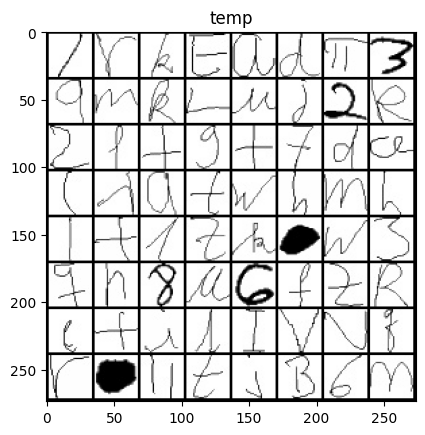

In [14]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)

imshow(out, title="temp")

## Model Training

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    if torch.cuda.is_available():
        model = model.cuda()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0
                count = 0
                for inputs, labels in dataloaders[phase]:
                    inputs = np.repeat(inputs, 3, axis=1)
                    count += len(labels)
                    if torch.cuda.is_available():
                        inputs = inputs.cuda()
                        labels = labels.cuda()

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                        
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / count
                epoch_acc = running_corrects.double() / count

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # if it errors here u probably have to do the same grayscale to rgb stacking i did earlier
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.repeat(1, 3, 1, 1)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Summarize pre-trained ResNet18

In [6]:
from torchinfo import summary

model_ft = models.resnet18(weights='IMAGENET1K_V1')
summary(model=model_ft, 
        verbose=0,
        input_size=(64, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 1000]           --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 16, 16]     9,408                True
├─BatchNorm2d (bn1)                      [64, 64, 16, 16]     [64, 64, 16, 16]     128                  True
├─ReLU (relu)                            [64, 64, 16, 16]     [64, 64, 16, 16]     --                   --
├─MaxPool2d (maxpool)                    [64, 64, 16, 16]     [64, 64, 8, 8]       --                   --
├─Sequential (layer1)                    [64, 64, 8, 8]       [64, 64, 8, 8]       --                   True
│    └─BasicBlock (0)                    [64, 64, 8, 8]       [64, 64, 8, 8]       --                   True
│    │    └─Conv2d (conv1)               [64, 64, 8, 8]       [64, 64, 8, 8]       36,864               True
│    │    └─BatchN

Modify last linear classification layer and freeze previous layers in preparation for transfer learning

In [7]:
for param in model_ft.parameters():
    param.requires_grad = False

# alter output size of last linear layer (fc)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

summary(model=model_ft, 
        verbose=0,
        input_size=(64, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [64, 3, 32, 32]      [64, 43]             --                   Partial
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 64, 16, 16]     (9,408)              False
├─BatchNorm2d (bn1)                      [64, 64, 16, 16]     [64, 64, 16, 16]     (128)                False
├─ReLU (relu)                            [64, 64, 16, 16]     [64, 64, 16, 16]     --                   --
├─MaxPool2d (maxpool)                    [64, 64, 16, 16]     [64, 64, 8, 8]       --                   --
├─Sequential (layer1)                    [64, 64, 8, 8]       [64, 64, 8, 8]       --                   False
│    └─BasicBlock (0)                    [64, 64, 8, 8]       [64, 64, 8, 8]       --                   False
│    │    └─Conv2d (conv1)               [64, 64, 8, 8]       [64, 64, 8, 8]       (36,864)             False
│    │    

Initialize loss criterion and training optimizer

In [8]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Training loop

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 2.4433 Acc: 0.3827
val Loss: 1.9379 Acc: 0.5016

Epoch 1/24
----------
train Loss: 1.8879 Acc: 0.5053
val Loss: 1.7510 Acc: 0.5396

Epoch 2/24
----------
train Loss: 1.7504 Acc: 0.5334
val Loss: 1.6454 Acc: 0.5619

Epoch 3/24
----------
train Loss: 1.6777 Acc: 0.5490
val Loss: 1.5740 Acc: 0.5765

Epoch 4/24
----------
train Loss: 1.6218 Acc: 0.5594
val Loss: 1.5451 Acc: 0.5822

Epoch 5/24
----------
train Loss: 1.5861 Acc: 0.5690
val Loss: 1.5056 Acc: 0.5951

Epoch 6/24
----------
train Loss: 1.5596 Acc: 0.5718
val Loss: 1.4854 Acc: 0.5974

Epoch 7/24
----------
train Loss: 1.5290 Acc: 0.5830
val Loss: 1.4881 Acc: 0.5980

Epoch 8/24
----------
train Loss: 1.5239 Acc: 0.5835
val Loss: 1.4635 Acc: 0.6065

Epoch 9/24
----------
train Loss: 1.5197 Acc: 0.5863
val Loss: 1.4613 Acc: 0.6052

Epoch 10/24
----------
train Loss: 1.5154 Acc: 0.5844
val Loss: 1.4612 Acc: 0.6045

Epoch 11/24
----------
train Loss: 1.5183 Acc: 0.5860
val Loss: 1.4686 Acc: 0.6031

Ep

Model Visualization

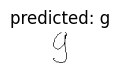

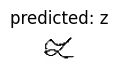

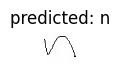

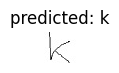

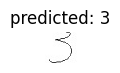

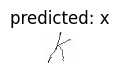

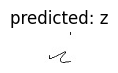

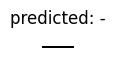

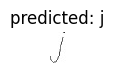

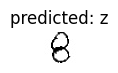

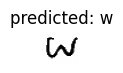

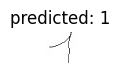

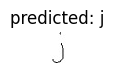

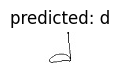

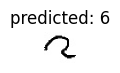

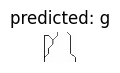

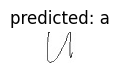

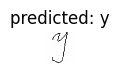

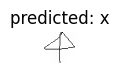

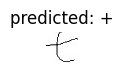

In [10]:
visualize_model(model_ft, 20)

In [11]:
torch.save(model_ft, 'transfer_model_resnet18.pth')